In [1]:
# импортируем библиотеки numpy, pandas и missingno
import numpy as np
import pandas as pd
import missingno as msno
# импортируем модуль stats библиотеки scipy
from scipy import stats
# импортируем функцию train_test_split(), с помощью
# которой разбиваем данные на обучающие и тестовые
from sklearn.model_selection import train_test_split
# импортируем классы SimpleImputer, StandardScaler, Pipeline
# и функцию cross_val_score для нашей функции importance_auc()
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
# импортируем функцию roc_auc_score() для
# вычисления AUC-ROC
from sklearn.metrics import roc_auc_score
# импортируем класс LogisticRegression
from sklearn.linear_model import LogisticRegression
# импортируем собственный класс логистической регрессии
from custom_logreg_classes import RegularizedLogisticRegression_Newton

In [2]:
# считываем данные
data = pd.read_csv('Data/cs-training.csv', 
                   index_col='Unnamed: 0')
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
# смотрим типы переменных и информацию о количестве пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

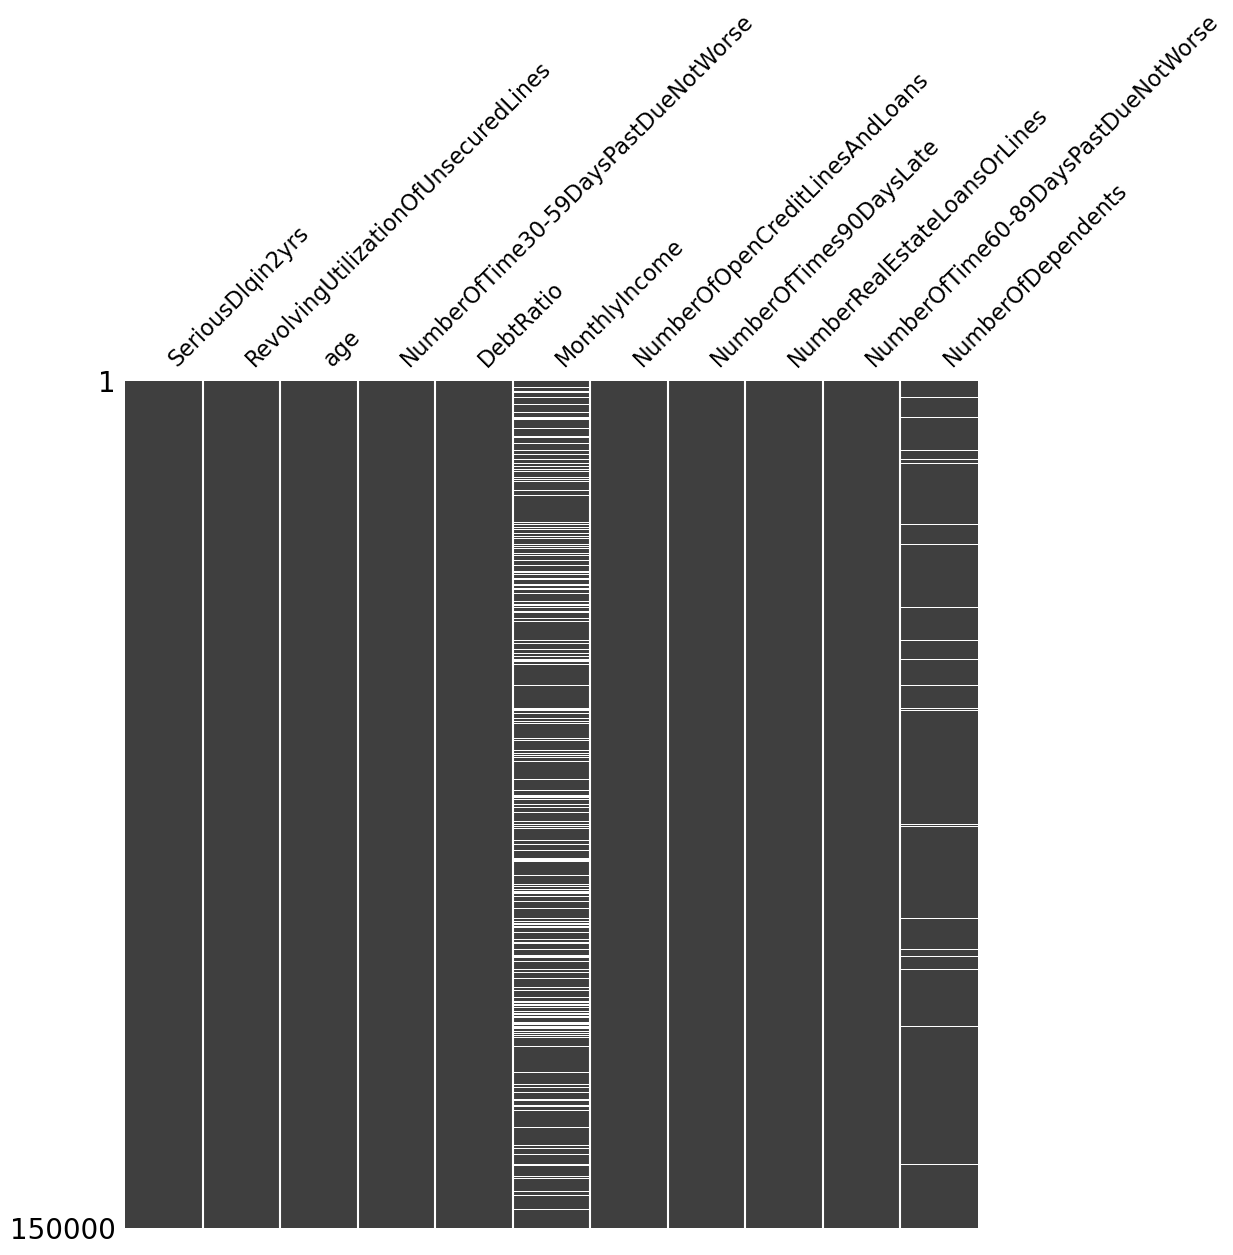

In [4]:
# визуализируем пропуски с помощью missingno
msno.matrix(data, sparkline=False, figsize=(11, 11));

In [5]:
# смотрим статистики количественных переменных
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000,150000.000,150000.000,150000.000,150000.000,120269.000,150000.000,150000.000,150000.000,150000.000,146076.000
mean,0.067,6.048,52.295,0.421,353.005,6670.221,8.453,0.266,1.018,0.240,0.757
std,0.250,249.755,14.772,4.193,2037.819,14384.674,5.146,4.169,1.130,4.155,1.115
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.030,41.000,0.000,0.175,3400.000,5.000,0.000,0.000,0.000,0.000
50%,0.000,0.154,52.000,0.000,0.367,5400.000,8.000,0.000,1.000,0.000,0.000
75%,0.000,0.559,63.000,0.000,0.868,8249.000,11.000,0.000,2.000,0.000,1.000
max,1.000,50708.000,109.000,98.000,329664.000,3008750.000,58.000,98.000,54.000,98.000,20.000


In [6]:
# выведем 10 наибольших значений MonthlyIncome
data['MonthlyIncome'].nlargest(10)

73764    3008750.000
137141   1794060.000
111366   1560100.000
50641    1072500.000
122544    835040.000
123292    730483.000
93565     702500.000
96550     699530.000
119137    649587.000
37079     629000.000
Name: MonthlyIncome, dtype: float64

In [7]:
# взглянем на значения MonthlyIncome больше 500000
data[data['MonthlyIncome'] > 500000]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
35974,0,0.440,64,0,0.004,582369.000,11,0,0,0,1.000
37079,0,0.000,83,0,0.000,629000.000,3,0,0,0,0.000
50641,0,0.469,44,1,0.005,1072500.000,9,0,2,0,1.000
73764,0,0.007,52,0,0.001,3008750.000,10,0,1,0,3.000
93565,0,0.072,50,0,0.008,702500.000,12,0,4,0,2.000
96550,0,0.064,52,0,0.004,699530.000,11,0,2,0,1.000
111366,0,0.164,44,0,0.004,1560100.000,12,0,4,0,2.000
119137,0,0.151,49,0,0.001,649587.000,8,0,0,1,3.000
122544,0,0.042,55,0,0.000,835040.000,8,0,0,0,0.000
123292,0,0.226,67,1,0.006,730483.000,23,0,1,0,0.000


In [8]:
# взглянем на значения MonthlyIncome менее 1200
data[data['MonthlyIncome'] < 1200]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
15,0,0.020,76,0,477.000,0.000,6,0,1,0,0.000
20,0,0.603,25,0,0.066,333.000,2,0,0,0,0.000
32,0,1.000,24,0,0.473,750.000,1,0,0,0,0.000
39,0,0.364,26,0,0.010,1000.000,1,0,0,0,0.000
45,0,0.369,68,0,1687.500,1.000,31,0,1,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...
149883,0,0.062,77,0,714.500,1.000,3,0,0,0,0.000
149951,0,0.005,61,0,1940.000,0.000,10,0,1,0,0.000
149955,1,1.000,46,0,170.398,401.000,3,2,0,0,2.000
149962,1,0.920,31,1,0.177,1125.000,4,1,0,0,0.000


In [9]:
# взглянем на пропуски переменной MonthlyIncome
data[data['MonthlyIncome'].isnull()]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
7,0,0.306,57,0,5710.000,NaN,8,0,3,0,0.000
9,0,0.117,27,0,46.000,NaN,2,0,0,0,NaN
17,0,0.061,78,0,2058.000,NaN,10,0,2,0,0.000
33,0,0.083,62,0,977.000,NaN,6,0,1,0,0.000
42,0,0.073,81,0,75.000,NaN,7,0,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...
149977,0,0.001,76,0,60.000,NaN,5,0,0,0,0.000
149978,0,0.236,29,0,349.000,NaN,3,0,0,0,0.000
149985,0,0.038,84,0,25.000,NaN,5,0,0,0,0.000
149993,0,0.872,50,0,4132.000,NaN,11,0,1,0,3.000


In [10]:
# заменяем пропуски и значения меньше 1200 в MonthlyIncome
# минимально допустимым значением дохода
data['MonthlyIncome'] = np.where((data['MonthlyIncome'].isnull()) | 
                                 (data['MonthlyIncome'] < 1200), 
                                 1200, 
                                 data['MonthlyIncome'])

In [11]:
# значения переменной age меньше 18 заменяем
# минимально допустимым значением возраста
data['age'] = np.where(data['age'] < 18, 18, data['age'])

In [12]:
# пропуски в переменной NumberOfDependents заменяем нулем, 
# а значения больше 4 выделяем в отдельную категорию
data.loc[data['NumberOfDependents'].isnull(), 'NumberOfDependents'] = 0

In [13]:
# все значения переменной RevolvingUtilizationOfUnsecuredLines
# больше 2 пометим как пропуски
data['RevolvingUtilizationOfUnsecuredLines'] = np.where(
    data['RevolvingUtilizationOfUnsecuredLines'] > 2, 
    np.NaN, 
    data['RevolvingUtilizationOfUnsecuredLines'])

In [14]:
# создаем переменную Ratio - отношение количества 
# просрочек 90+ к общему количеству просрочек
sum_of_delinq = (data['NumberOfTimes90DaysLate'] + 
                 data['NumberOfTime30-59DaysPastDueNotWorse'] + 
                 data['NumberOfTime60-89DaysPastDueNotWorse'])

cond = (data['NumberOfTimes90DaysLate'] == 0) | (sum_of_delinq == 0)
data['Ratio'] = np.where(
    cond, 0, data['NumberOfTimes90DaysLate'] / sum_of_delinq)

In [15]:
# создаем индикатор нулевых значений переменной 
# NumberOfOpenCreditLinesAndLoans
data['NumberOfOpenCreditLinesAndLoans_is_0'] = np.where(
    data['NumberOfOpenCreditLinesAndLoans'] == 0, 'T', 'F')

In [16]:
# создаем индикатор нулевых значений переменной 
# NumberRealEstateLoansOrLines
data['NumberRealEstateLoansOrLines_is_0'] = np.where(
    data['NumberRealEstateLoansOrLines'] == 0, 'T', 'F')

In [17]:
# создаем индикатор нулевых значений переменной 
# RevolvingUtilizationOfUnsecuredLines
data['RevolvingUtilizationOfUnsecuredLines_is_0'] = np.where(
    data['RevolvingUtilizationOfUnsecuredLines'] == 0, 'T', 'F')

In [18]:
# смотрим уникальные значения целочисленных переменных, 
# характеризующих глубину просрочки
for col in ['NumberOfTime30-59DaysPastDueNotWorse', 
            'NumberOfTime60-89DaysPastDueNotWorse',
            'NumberOfTimes90DaysLate']:
    print(f"{col}:\n{data[col].unique()}\n")

NumberOfTime30-59DaysPastDueNotWorse:
[ 2  0  1  3  4  5  7 10  6 98 12  8  9 96 13 11]

NumberOfTime60-89DaysPastDueNotWorse:
[ 0  1  2  5  3 98  4  6  7  8 96 11  9]

NumberOfTimes90DaysLate:
[ 0  1  3  2  5  4 98 10  9  6  7  8 15 96 11 13 14 17 12]



In [19]:
# преобразовываем переменные в категориальные, применив
# биннинг и перевод в единый строковый формат
for col in ['NumberOfTime30-59DaysPastDueNotWorse', 
            'NumberOfTime60-89DaysPastDueNotWorse',
            'NumberOfTimes90DaysLate',
            'NumberOfDependents']:
    data.loc[data[col] > 3, col] = 4
    data[col] = data[col].apply(lambda x: f"cat_{x}")

# смотрим частоты
for col in ['NumberOfTime30-59DaysPastDueNotWorse', 
            'NumberOfTime60-89DaysPastDueNotWorse',
            'NumberOfTimes90DaysLate',
            'NumberOfDependents']:
    print(data[col].value_counts())
    print('')

cat_0    126018
cat_1     16033
cat_2      4598
cat_3      1754
cat_4      1597
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

cat_0    142396
cat_1      5731
cat_2      1118
cat_4       437
cat_3       318
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

cat_0    141662
cat_1      5243
cat_2      1555
cat_4       873
cat_3       667
Name: NumberOfTimes90DaysLate, dtype: int64

cat_0.0    90826
cat_1.0    26316
cat_2.0    19522
cat_3.0     9483
cat_4.0     3853
Name: NumberOfDependents, dtype: int64



In [20]:
# пишем функцию, которая создает взаимодействие 
# в результате конъюнкции переменных 
# f1 и f2
def make_interact(df, interact_list):
    for i in lst:
        f1 = i[0]
        f2 = i[1]
        df[f1 + ' + ' + f2 + '_interact'] = (df[f1].astype(str) + ' + ' 
                                             + df[f2].astype(str))

In [21]:
# создаем список списков - список 2-факторных взаимодействий
lst = [
    ['NumberOfDependents', 
     'NumberOfTime30-59DaysPastDueNotWorse'],
    ['NumberOfTime60-89DaysPastDueNotWorse', 
     'NumberOfTimes90DaysLate'],
    ['NumberOfTime30-59DaysPastDueNotWorse', 
     'NumberOfTime60-89DaysPastDueNotWorse'],
    ['NumberRealEstateLoansOrLines_is_0', 
     'NumberOfTimes90DaysLate'],
    ['NumberOfOpenCreditLinesAndLoans_is_0', 
     'NumberOfTimes90DaysLate']
]

# создаем взаимодействия
make_interact(data, interact_list=lst)
data

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Ratio,NumberOfOpenCreditLinesAndLoans_is_0,NumberRealEstateLoansOrLines_is_0,RevolvingUtilizationOfUnsecuredLines_is_0,NumberOfDependents + NumberOfTime30-59DaysPastDueNotWorse_interact,NumberOfTime60-89DaysPastDueNotWorse + NumberOfTimes90DaysLate_interact,NumberOfTime30-59DaysPastDueNotWorse + NumberOfTime60-89DaysPastDueNotWorse_interact,NumberRealEstateLoansOrLines_is_0 + NumberOfTimes90DaysLate_interact,NumberOfOpenCreditLinesAndLoans_is_0 + NumberOfTimes90DaysLate_interact
1,1,0.766,45,cat_2,0.803,9120.000,13,cat_0,6,cat_0,cat_2.0,0.000,F,F,F,cat_2.0 + cat_2,cat_0 + cat_0,cat_2 + cat_0,F + cat_0,F + cat_0
2,0,0.957,40,cat_0,0.122,2600.000,4,cat_0,0,cat_0,cat_1.0,0.000,F,T,F,cat_1.0 + cat_0,cat_0 + cat_0,cat_0 + cat_0,T + cat_0,F + cat_0
3,0,0.658,38,cat_1,0.085,3042.000,2,cat_1,0,cat_0,cat_0.0,0.500,F,T,F,cat_0.0 + cat_1,cat_0 + cat_1,cat_1 + cat_0,T + cat_1,F + cat_1
4,0,0.234,30,cat_0,0.036,3300.000,5,cat_0,0,cat_0,cat_0.0,0.000,F,T,F,cat_0.0 + cat_0,cat_0 + cat_0,cat_0 + cat_0,T + cat_0,F + cat_0
5,0,0.907,49,cat_1,0.025,63588.000,7,cat_0,1,cat_0,cat_0.0,0.000,F,F,F,cat_0.0 + cat_1,cat_0 + cat_0,cat_1 + cat_0,F + cat_0,F + cat_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.041,74,cat_0,0.225,2100.000,4,cat_0,1,cat_0,cat_0.0,0.000,F,F,F,cat_0.0 + cat_0,cat_0 + cat_0,cat_0 + cat_0,F + cat_0,F + cat_0
149997,0,0.300,44,cat_0,0.717,5584.000,4,cat_0,1,cat_0,cat_2.0,0.000,F,F,F,cat_2.0 + cat_0,cat_0 + cat_0,cat_0 + cat_0,F + cat_0,F + cat_0
149998,0,0.246,58,cat_0,3870.000,1200.000,18,cat_0,1,cat_0,cat_0.0,0.000,F,F,F,cat_0.0 + cat_0,cat_0 + cat_0,cat_0 + cat_0,F + cat_0,F + cat_0
149999,0,0.000,30,cat_0,0.000,5716.000,4,cat_0,0,cat_0,cat_0.0,0.000,F,T,T,cat_0.0 + cat_0,cat_0 + cat_0,cat_0 + cat_0,T + cat_0,F + cat_0


In [22]:
# создаем обучающий массив предикторов, тестовый массив предикторов,
# обучающий массив меток, тестовый массив меток
train, test, y_train, y_test = train_test_split(
    data.drop('SeriousDlqin2yrs', axis=1), 
    data['SeriousDlqin2yrs'], 
    test_size=.3, 
    stratify=data['SeriousDlqin2yrs'], 
    random_state=100)

In [23]:
# создаем обучающий и тестовый наборы для h2o
h2o_train, h2o_test, _, _ = train_test_split(
    data, data, test_size=.3, 
    stratify=data['SeriousDlqin2yrs'], 
    random_state=100)

# записываем наборы в CSV-файлы
h2o_train.to_csv('h2o_train.csv', sep=';', index=False)
h2o_test.to_csv('h2o_test.csv', sep=';', index=False)

In [24]:
# пишем функцию, вычисляющую AUC для модели с одним предиктором
def importance_auc(train, y_train, imp_strategy):
    # создаем копию обучающего набора
    train_copy = train.copy()
    # создаем список переменных
    col_list = train_copy.select_dtypes(include=['number']).columns  
    # создаем список, в который будем записывать auc
    auc_list = []
    for i in col_list:
        pipe = Pipeline([
            ('imputer', SimpleImputer(strategy=imp_strategy)),
            ('scaler', StandardScaler()), 
            ('logreg', LogisticRegression(solver='liblinear'))
        ])     
        auc = cross_val_score(pipe, 
                              train_copy[[i]], 
                              y_train, 
                              scoring='roc_auc', 
                              cv=5).mean()
        auc_list.append(auc)
    
    result = pd.DataFrame({'Переменная': col_list,
                           'AUC': auc_list})
    return np.round(result.sort_values(
        by='AUC', ascending=False), 3) 

In [25]:
# применяем функцию importance_auc()
importance_auc(train, y_train, 'median')

,Переменная,AUC
0,RevolvingUtilizationOfUnsecuredLines,0.779
6,Ratio,0.652
1,age,0.634
4,NumberOfOpenCreditLinesAndLoans,0.540
5,NumberRealEstateLoansOrLines,0.535
3,MonthlyIncome,0.532
2,DebtRatio,0.475


In [26]:
# выполняем импутацию пропусков в переменной 
# RevolvingUtilizationOfUnsecuredLines средним
train['RevolvingUtilizationOfUnsecuredLines'].fillna(
    train['RevolvingUtilizationOfUnsecuredLines'].mean(), inplace=True)
test['RevolvingUtilizationOfUnsecuredLines'].fillna(
    train['RevolvingUtilizationOfUnsecuredLines'].mean(), inplace=True)

In [27]:
# выполняем логарифмическое преобразование 
# переменной MonthlyIncome
train['MonthlyIncome'] = np.log(train['MonthlyIncome'].clip(0.01))
test['MonthlyIncome'] = np.log(test['MonthlyIncome'].clip(0.01))

In [28]:
# выводим описательные статистики
train['DebtRatio'].describe()

count   105000.000
mean       353.037
std       2051.316
min          0.000
25%          0.175
50%          0.367
75%          0.870
max     329664.000
Name: DebtRatio, dtype: float64

In [29]:
# допустим, мы знаем, что не выдаем кредиты с коэффициентом 
# долговой нагрузки больше 0.7, найдем соответствующий этому
# значению процентиль
stats.percentileofscore(train['DebtRatio'], 0.7)

71.64095238095238

In [30]:
# проверим, какому числу соответствует этот процентиль
np.percentile(train['DebtRatio'], 71.641)

0.6999722155381308

In [31]:
# создаем копию серии
debt_ratio = train['DebtRatio'].copy()

# выполняем винзоризацию
debt_ratio = stats.mstats.winsorize(debt_ratio, 
                                    limits=(0, 0.28359))
# выводим описательные статистики
pd.Series(debt_ratio).describe()

/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


count   105000.000
mean         0.390
std          0.250
min          0.000
25%          0.175
50%          0.367
75%          0.700
max          0.700
dtype: float64

In [32]:
# создаем собственный класс, выполняющий винзоризацию
class OutlierRemover():
    """
    Параметры:
    lower_quantile: float, по умолчанию 0.25
        Нижний квантиль.
    upper_quantile: float, по умолчанию 0.75
        Верхний квантиль.
    k: float, по умолчанию 1.5
        Коэффициент.
    copy: bool, по умолчанию True
        Возвращает копию.
    """
    def __init__(self, copy=True, lower_quantile=0.25, 
                 upper_quantile=0.75, k=1.5):
        # все параметры для инициализации публичных атрибутов 
        # должны быть заданы в методе __init__
        
        # публичные атрибуты
        self.copy = copy
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.k = k
        
    def __is_numpy(self, X):
        # частный метод, который с помощью функции isinstance()
        # проверяет, является ли наш объект массивом NumPy
        return isinstance(X, np.ndarray)
                
    def fit(self, X, y=None):
        # fit должен принимать в качестве аргументов X и y
        
        # обучение модели осуществляется прямо здесь
        # создаем пустой словарь, в котором ключами
        # будут имена/целые числа, а значениями - кортежами
        self._dict = {}
        
        # если 1D-массив, то переводим в 2D
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
            
        # записываем количество столбцов
        ncols = X.shape[1]
        
        # записываем результат __is_numpy()
        is_np = self.__is_numpy(X)
        
        # если объект - массив NumPy, выполняем следующие действия:
        if is_np:
            # по каждому столбцу массива NumPy
            for col in range(ncols):
                lower = np.quantile(X[:, col], self.lower_quantile)
                upper = np.quantile(X[:, col], self.upper_quantile)
                IQR = (upper - lower) * self.k
                self._dict[col] = (lower, upper, IQR)
        # в противном случае, т.е. если объект - датафрейм pandas,
        # выполняем следующие действия:
        else:
            # по каждому столбцу датафрейма pandas
            for col in X.columns:
                # вычисляем и записываем в словарь
                lower = X[col].quantile(self.lower_quantile)
                upper = X[col].quantile(self.upper_quantile)
                IQR = (upper - lower) * self.k
                self._dict[col] = (lower, upper, IQR)

        # fit возвращает self
        return self
    
    def transform(self, X):
        # transform принимает в качестве аргумента только X
        
        # выполняем копирование массива во избежание 
        # предупреждения SettingWithCopyWarning
        # "A value is trying to be set on a copy of 
        # a slice from a DataFrame (Происходит попытка изменить 
        # значение в копии среза данных датафрейма)"
        if self.copy:
            X = X.copy()
        
        # если 1D-массив, то переводим в 2D
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
            
        # записываем количество столбцов
        ncols = X.shape[1]
        
        # записываем результат __is_numpy()
        is_np = self.__is_numpy(X)
        
        # применяем преобразование к X
        # если объект - массив NumPy, выполняем следующие действия:
        if is_np:
            # по каждому столбцу массива NumPy
            for col in range(ncols):
                # заменяем
                X[:, col] = np.where(
                    X[:, col] < (self._dict[col][0] - self._dict[col][2]), 
                    self._dict[col][0] - self._dict[col][2], 
                    X[:, col])
                X[:, col] = np.where(
                    X[:, col] >= (self._dict[col][1] + self._dict[col][2]), 
                    self._dict[col][1] + self._dict[col][2], 
                    X[:, col])
                
        # в противном случае, т.е. если объект - датафрейм pandas,
        # выполняем следующие действия:
        else:
            # по каждому столбцу датафрейма pandas
            for col in X.columns:
                # заменяем
                X[col] = np.where(
                    X[col] < (self._dict[col][0] - self._dict[col][2]), 
                    self._dict[col][0] - self._dict[col][2], 
                    X[col])
                X[col] = np.where(
                    X[col] >= (self._dict[col][1] + self._dict[col][2]), 
                    self._dict[col][1] + self._dict[col][2], 
                    X[col]) 
        # transform возвращает X
        return X

In [33]:
# выполняем винзоризацию переменной DebtRatio
# с помощью нашего класса OutlierRemover
rem = OutlierRemover(lower_quantile=0, 
                     upper_quantile=0.8,
                     k=1.15)
rem.fit(train[['DebtRatio']])
train['DebtRatio'] = rem.transform(train[['DebtRatio']])
test['DebtRatio'] = rem.transform(test[['DebtRatio']])

In [34]:
# выполняем биннинг переменных DebtRatio и 
# RevolvingUtilizationOfUnsecuredLines
bins = np.round(np.arange(0.0, 1.05, 0.05), 2).tolist()
bins[0] = -1
for col in ['DebtRatio', 'RevolvingUtilizationOfUnsecuredLines']:
    train[col+'_bins'] = pd.cut(
        train[col], bins, labels=bins[1:]).astype('float')
    train.loc[(train[col] > 1), col+'_bins'] = 2
    test[col+'_bins'] = pd.cut(
        test[col], bins, labels=bins[1:]).astype('float')
    test.loc[(test[col] > 1), col+'_bins'] = 2

In [35]:
# преобразовываем DebtRatio_bins в категориальную переменную
train['DebtRatio_bins'] = train['DebtRatio_bins'].apply(lambda x: f"cat_{x}")
test['DebtRatio_bins'] = test['DebtRatio_bins'].apply(lambda x: f"cat_{x}")

In [36]:
# выполняем стандартизацию
num_cols = train.select_dtypes(include=['number']).columns.tolist()
train_copy = train.copy()
for col in num_cols:
    train[col] = (train[col] - train[col].mean()) / train[col].std()
    test[col] = (test[col] - train_copy[col].mean()) / train_copy[col].std()

In [37]:
# проверяем наличие пропусков
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


In [38]:
# выполняем дамми-кодирование
X_train = pd.get_dummies(train)
X_test = pd.get_dummies(test)

In [39]:
# проверяем количество признаков
print(X_train.shape[1], X_test.shape[1])

150 150


In [40]:
%%time

# строим модель логистической регрессии на основе
# класса LogisticRegression
logreg = LogisticRegression(solver='liblinear').fit(X_train, y_train)
print("AUC-ROC на обучающей выборке: {:.3f}".format(
    roc_auc_score(y_train, logreg.predict_proba(X_train)[:, 1])))
print("AUC-ROC на тестовой выборке: {:.3f}".format(
    roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])))

AUC-ROC на обучающей выборке: 0.864
AUC-ROC на тестовой выборке: 0.864
CPU times: user 1.78 s, sys: 263 ms, total: 2.04 s
Wall time: 1.37 s


In [41]:
%%time

# строим модель логистической регрессии на основе собственного 
# класса RegularizedLogisticRegression_Newton
custom_logreg = RegularizedLogisticRegression_Newton(
    lambda_=0.001, max_iter=2)
custom_logreg.fit(X_train, y_train)
print("AUC-ROC на обучающей выборке: {:.3f}".format(
    roc_auc_score(y_train, custom_logreg.predict_proba(X_train))))
print("AUC-ROC на тестовой выборке: {:.3f}".format(
    roc_auc_score(y_test, custom_logreg.predict_proba(X_test))))

AUC-ROC на обучающей выборке: 0.864
AUC-ROC на тестовой выборке: 0.864
CPU times: user 2.9 s, sys: 767 ms, total: 3.66 s
Wall time: 469 ms


In [42]:
# запишем коэффициенты, предварительно округлив до 3-го знака, 
# и названия предикторов в отдельные объекты
coef = np.round(logreg.coef_, 3)
feat_labels = X_train.columns

# запишем свободный член (константу) в отдельный объект, при этом
# переводим массив, полученный с помощью атрибута intercept_, 
# в скаляр с округлением до 3-го знака
intercept = np.round(logreg.intercept_.item(), 3)

# печатаем название "Константа"    
print("Константа:", intercept)
# печатаем название "Регрессионные коэффициенты"
print("Регрессионные коэффициенты:")
# для удобства сопоставим каждому названию 
# предиктора соответствующий коэффициент
for c, feature in zip(coef[0], feat_labels):
    print(feature, c)

Константа: -0.224
Регрессионные коэффициенты:
RevolvingUtilizationOfUnsecuredLines 0.441
age -0.235
DebtRatio -0.301
MonthlyIncome -0.044
NumberOfOpenCreditLinesAndLoans 0.166
NumberRealEstateLoansOrLines 0.154
Ratio 0.274
RevolvingUtilizationOfUnsecuredLines_bins 0.158
NumberOfTime30-59DaysPastDueNotWorse_cat_0 -0.462
NumberOfTime30-59DaysPastDueNotWorse_cat_1 -0.008
NumberOfTime30-59DaysPastDueNotWorse_cat_2 -0.003
NumberOfTime30-59DaysPastDueNotWorse_cat_3 0.128
NumberOfTime30-59DaysPastDueNotWorse_cat_4 0.121
NumberOfTimes90DaysLate_cat_0 -0.068
NumberOfTimes90DaysLate_cat_1 -0.156
NumberOfTimes90DaysLate_cat_2 -0.083
NumberOfTimes90DaysLate_cat_3 0.048
NumberOfTimes90DaysLate_cat_4 0.035
NumberOfTime60-89DaysPastDueNotWorse_cat_0 -0.444
NumberOfTime60-89DaysPastDueNotWorse_cat_1 -0.199
NumberOfTime60-89DaysPastDueNotWorse_cat_2 0.025
NumberOfTime60-89DaysPastDueNotWorse_cat_3 0.227
NumberOfTime60-89DaysPastDueNotWorse_cat_4 0.167
NumberOfDependents_cat_0.0 -0.083
NumberOfDependent

In [43]:
# вычислим экспоненциальные коэффициенты
# и запишем их в отдельный объект
exp_coef = np.round(np.exp(coef), 3)

# печатаем название "Экспоненциальные коэффициенты"
print("Экспоненциальные коэффициенты:")
# для удобства сопоставим каждому названию 
# предиктора соответствующий коэффициент
for c, feature in zip(exp_coef[0], feat_labels):
    print(feature, c)

Экспоненциальные коэффициенты:
RevolvingUtilizationOfUnsecuredLines 1.554
age 0.791
DebtRatio 0.74
MonthlyIncome 0.957
NumberOfOpenCreditLinesAndLoans 1.181
NumberRealEstateLoansOrLines 1.166
Ratio 1.315
RevolvingUtilizationOfUnsecuredLines_bins 1.171
NumberOfTime30-59DaysPastDueNotWorse_cat_0 0.63
NumberOfTime30-59DaysPastDueNotWorse_cat_1 0.992
NumberOfTime30-59DaysPastDueNotWorse_cat_2 0.997
NumberOfTime30-59DaysPastDueNotWorse_cat_3 1.137
NumberOfTime30-59DaysPastDueNotWorse_cat_4 1.129
NumberOfTimes90DaysLate_cat_0 0.934
NumberOfTimes90DaysLate_cat_1 0.856
NumberOfTimes90DaysLate_cat_2 0.92
NumberOfTimes90DaysLate_cat_3 1.049
NumberOfTimes90DaysLate_cat_4 1.036
NumberOfTime60-89DaysPastDueNotWorse_cat_0 0.641
NumberOfTime60-89DaysPastDueNotWorse_cat_1 0.82
NumberOfTime60-89DaysPastDueNotWorse_cat_2 1.025
NumberOfTime60-89DaysPastDueNotWorse_cat_3 1.255
NumberOfTime60-89DaysPastDueNotWorse_cat_4 1.182
NumberOfDependents_cat_0.0 0.92
NumberOfDependents_cat_1.0 0.924
NumberOfDependen

In [44]:
# посмотрим, сколько у нас предикторов
X_train.shape[1]

150

In [45]:
# импортируем функцию mutual_info_classif(), 
# вычисляющую взаимную информацию
from sklearn.feature_selection import mutual_info_classif

In [46]:
# отключаем экспоненциальное представление
np.set_printoptions(precision=None, suppress=True)

# вычисляем взаимную информацию между предикторами 
# и зависимой переменной, функция возвращает 
# взаимную информацию для каждого предиктора,
# чем меньше значение, тем меньше информации 
# о зависимой переменной несет наш предиктор
mi = mutual_info_classif(X_train, y_train, random_state=0)
mi

array([0.03554945, 0.00691024, 0.0063855 , 0.00431225, 0.00299539,
       0.00502602, 0.03543437, 0.03886811, 0.04024899, 0.00511791,
       0.0073015 , 0.00448629, 0.00625128, 0.05134628, 0.01132081,
       0.00746872, 0.00569454, 0.00682421, 0.04033447, 0.01069616,
       0.00517347, 0.00195424, 0.00305554, 0.00961195, 0.00127681,
       0.00123597, 0.00132315, 0.00098079, 0.02494812, 0.00242526,
       0.01045547, 0.00457554, 0.02134913, 0.00150772, 0.01554666,
       0.00308106, 0.00341671, 0.00202696, 0.00355244, 0.00085887,
       0.00094575, 0.0014693 , 0.00230439, 0.        , 0.00107891,
       0.00141593, 0.00078324, 0.001349  , 0.00166957, 0.00064534,
       0.00054897, 0.        , 0.0005893 , 0.        , 0.00048398,
       0.00009747, 0.00022171, 0.        , 0.        , 0.05611989,
       0.00593722, 0.00350718, 0.00241599, 0.00244635, 0.00449697,
       0.004168  , 0.00254333, 0.        , 0.0014999 , 0.00203501,
       0.00039286, 0.00199841, 0.00099514, 0.        , 0.00074

In [47]:
# увеличиваем количество строк вывода
pd.set_option('display.max_rows', 200)

# для большей ясности добавим имена переменных и
# отсортируем по убыванию взаимной информации

# превращаем массив NumPy со значениями
# взаимной информации в серию
mi = pd.Series(mi)
# метками индекса будут имена переменных
mi.index = X_train.columns
# сортируем по убыванию
mi.sort_values(ascending=False)

NumberOfTime60-89DaysPastDueNotWorse + NumberOfTimes90DaysLate_interact_cat_0 + cat_0                0.056
NumberOfTimes90DaysLate_cat_0                                                                        0.051
NumberOfOpenCreditLinesAndLoans_is_0 + NumberOfTimes90DaysLate_interact_F + cat_0                    0.049
NumberOfTime30-59DaysPastDueNotWorse + NumberOfTime60-89DaysPastDueNotWorse_interact_cat_0 + cat_0   0.045
NumberOfTime60-89DaysPastDueNotWorse_cat_0                                                           0.040
NumberOfTime30-59DaysPastDueNotWorse_cat_0                                                           0.040
RevolvingUtilizationOfUnsecuredLines_bins                                                            0.039
RevolvingUtilizationOfUnsecuredLines                                                                 0.036
Ratio                                                                                                0.035
NumberOfOpenCreditLinesAndLoans_is_0_

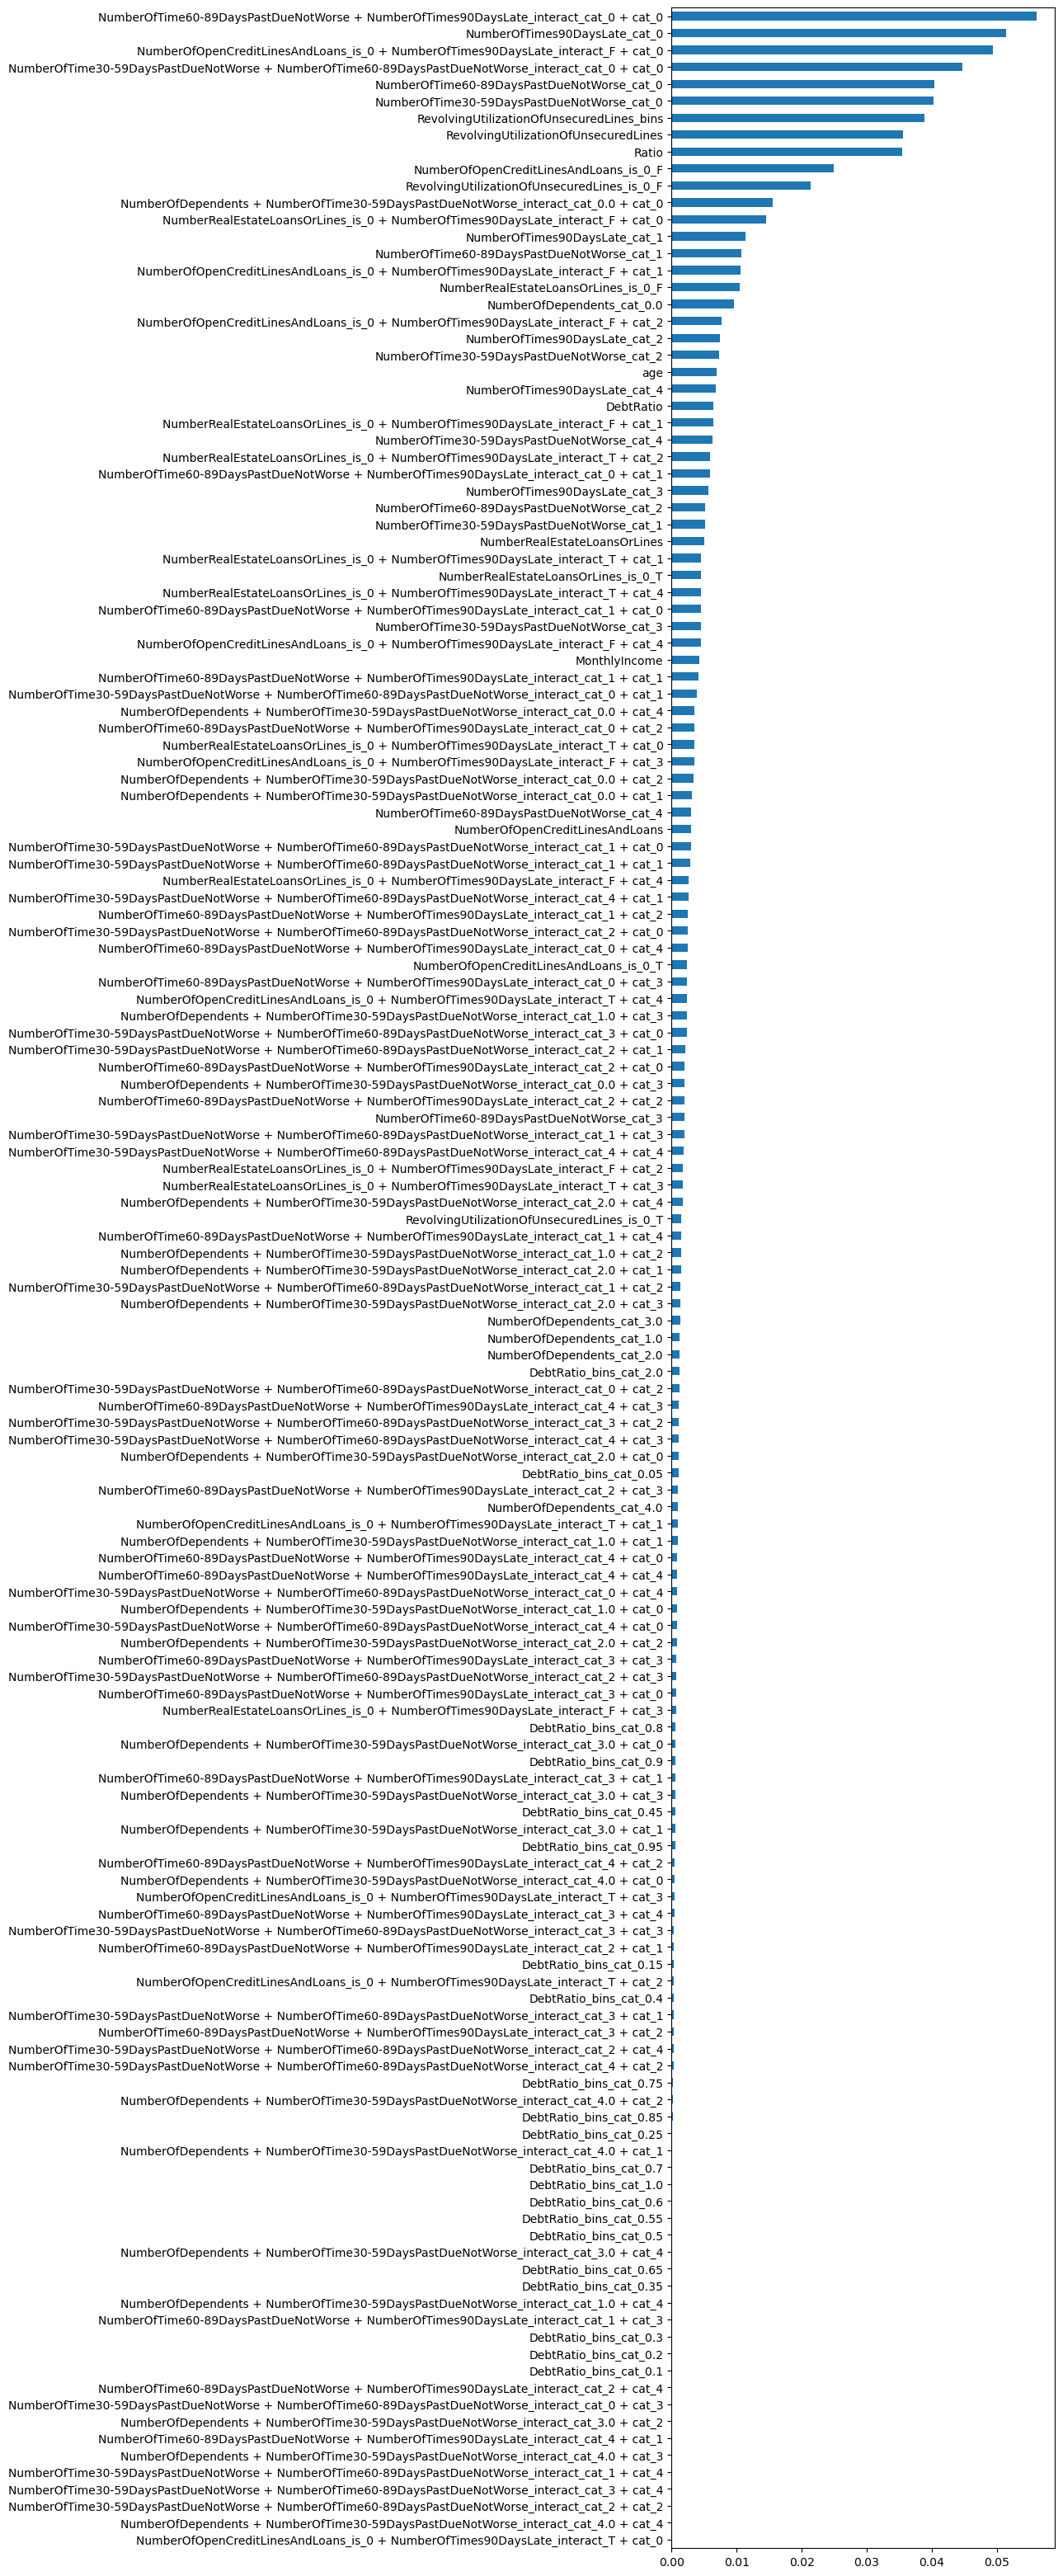

In [48]:
# строим график значений взаимной информации
mi.sort_values().plot.barh(figsize=(6, 40));

In [49]:
# отбираем переменные выше порога и формируем список
select_columns = mi.index[mi > 0.0003].tolist()
print(len(select_columns))

121


In [50]:
# строим модель логистической регрессии на наборах предикторов,
# сокращенных с помощью взаимной информации 
logreg_mi = LogisticRegression(solver='liblinear').fit(
    X_train[select_columns], y_train)
print("AUC-ROC на обучающей выборке: {:.3f}".format(
    roc_auc_score(y_train, logreg_mi.predict_proba(
        X_train[select_columns])[:, 1])))
print("AUC-ROC на тестовой выборке: {:.3f}".format(
    roc_auc_score(y_test, logreg_mi.predict_proba(
        X_test[select_columns])[:, 1])))

AUC-ROC на обучающей выборке: 0.863
AUC-ROC на тестовой выборке: 0.862


In [51]:
# импортируем BoostARoota
from boostaroota import BoostARoota
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(random_state=42)

# обучаем BoostARoota
br = BoostARoota(metric='logloss', clf=clf)
br.fit(X_train, y_train)

/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:39: UserWarning: You entered values for metric and clf, defaulting to clf and ignoring metric
  warnings.warn('You entered values for metric and clf, defaulting to clf and ignoring metric')


Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  1  iteration:  4


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore2_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  1  iteration:  5


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x', 'fscore3_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  1  iteration:  6


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore4_x', 'fscore2_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  1  iteration:  7


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x', 'fscore5_x', 'fscore3_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  1  iteration:  8


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore6_x', 'fscore4_x', 'fscore2_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  1  iteration:  9


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x', 'fscore5_x', 'fscore3_x', 'fscore7_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')
/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:184: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Mean'] = df.mean(axis=1)


Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  2  iteration:  4


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore2_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  2  iteration:  5


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x', 'fscore3_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  2  iteration:  6


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore4_x', 'fscore2_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  2  iteration:  7


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x', 'fscore5_x', 'fscore3_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  2  iteration:  8


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore6_x', 'fscore4_x', 'fscore2_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  2  iteration:  9


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x', 'fscore5_x', 'fscore3_x', 'fscore7_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')
/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:184: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Mean'] = df.mean(axis=1)


Round:  2  iteration:  10
Round:  3  iteration:  1
Round:  3  iteration:  2
Round:  3  iteration:  3


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  3  iteration:  4


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore2_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  3  iteration:  5


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x', 'fscore3_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  3  iteration:  6


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore4_x', 'fscore2_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  3  iteration:  7


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x', 'fscore5_x', 'fscore3_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  3  iteration:  8


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore6_x', 'fscore4_x', 'fscore2_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')


Round:  3  iteration:  9
Round:  3  iteration:  10
BoostARoota ran successfully! Algorithm went through  3  rounds.


/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:180: FutureWarning: Passing 'suffixes' which cause duplicate columns {'fscore1_x', 'fscore5_x', 'fscore3_x', 'fscore7_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, df2, on='feature', how='outer')
/Users/artemgruzdev/anaconda3/lib/python3.10/site-packages/boostaroota/boostaroota.py:184: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['Mean'] = df.mean(axis=1)


In [52]:
# получаем массивы предикторов, отобранные с помощью BoostARoota
X_train_boosta = br.transform(X_train)
X_test_boosta = br.transform(X_test)

In [53]:
# посмотрим, сколько предикторов оставила BoostARoota
print(X_train_boosta.shape)

(105000, 66)


In [54]:
# посмотрим, какие предикторы оставила BoostARoota
X_train_boosta.columns.tolist()

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'Ratio',
 'RevolvingUtilizationOfUnsecuredLines_bins',
 'NumberOfTime30-59DaysPastDueNotWorse_cat_0',
 'NumberOfTime30-59DaysPastDueNotWorse_cat_1',
 'NumberOfTime30-59DaysPastDueNotWorse_cat_2',
 'NumberOfTime30-59DaysPastDueNotWorse_cat_3',
 'NumberOfTime30-59DaysPastDueNotWorse_cat_4',
 'NumberOfTimes90DaysLate_cat_0',
 'NumberOfTimes90DaysLate_cat_1',
 'NumberOfTimes90DaysLate_cat_2',
 'NumberOfTimes90DaysLate_cat_4',
 'NumberOfTime60-89DaysPastDueNotWorse_cat_0',
 'NumberOfTime60-89DaysPastDueNotWorse_cat_1',
 'NumberOfTime60-89DaysPastDueNotWorse_cat_2',
 'NumberOfDependents_cat_0.0',
 'NumberOfDependents_cat_1.0',
 'NumberOfDependents_cat_2.0',
 'NumberOfDependents_cat_3.0',
 'NumberOfDependents_cat_4.0',
 'NumberRealEstateLoansOrLines_is_0_F',
 'NumberRealEstateLoansOrLines_is_0_T',
 'NumberOfDependents + NumberOfTime30-59DaysPas

In [55]:
# строим модель логистической регрессии на наборах предикторов,
# сокращенных с помощью BoostARoota
logreg_boosta = LogisticRegression(solver='liblinear').fit(
    X_train_boosta, y_train)
print("AUC-ROC на тестовой выборке: {:.3f}".format(
    roc_auc_score(y_train, logreg_boosta.predict_proba(
        X_train_boosta)[:, 1])))
print("AUC-ROC на тестовой выборке: {:.3f}".format(
    roc_auc_score(y_test, logreg_boosta.predict_proba(
        X_test_boosta)[:, 1])))

AUC-ROC на тестовой выборке: 0.863
AUC-ROC на тестовой выборке: 0.863
